# Chaper 14: Vectorization to Speed Up Deep Reinforcement Learning



***
***“Mathematics is the art of reducing any problem to linear algebra.”***

-- William Stein 
***





In Chapter 13, we explored self-play deep reinforcement learning and its application to the coin game. Now, we’re extending this approach to two additional games, Tic Tac Toe and Connect Four, in this and the following chapter. This transition raises three key challenges.

Firstly, unlike the coin game, where illegal moves are non-existent as players simply choose to remove one or two coins per turn, Tic Tac Toe and Connect Four have a decreasing number of legal moves as the game advances. For example, Tic Tac Toe starts with nine possible moves, which reduces to eight in the next turn, and so on. To address this, we’ll penalize illegal moves by assigning negative rewards. However, we’ll also differentiate between poorly chosen legal moves that lead to a loss and outright illegal moves. To assign credit properly, we penalize a bad legal move and all preceding moves. In contrast, we’ll only penalize the specific illegal move, not moves before illegal moves.

Secondly, the computational demands of training for Tic Tac Toe and Connect Four are significantly higher than for the coin game. To tackle this, we’ll shift from using loops to vectorization, a method that significantly speeds up the training process. You’ll understand the concept of vectorization, and learn how it facilitates rapid execution. The implementation of vectorization in various functions will be a key focus in this and the next chapter.

Finally, this chapter will guide you through the process of encoding the game board in a player-independent manner. In the coin game, the strategy remains the same regardless of the player, as it’s independent of whether Player 1 or Player 2 is playing. However, in games like Tic Tac Toe and Connect Four, the strategies vary significantly depending on the player’s turn and the existing layout of game pieces on the board. You’ll learn to encode the board in such a way that the current player’s
pieces are represented as 1 and the opponent’s as −1, effectively transforming a player-dependent board into a player-independent format. This conversion to playerindependent encoding allows the use of the same neural network for training both players.

More specifically, this chapter focuses on developing a single model for both Player X and Player O in Tic Tac Toe. With the game board cells represented as 1 for Player X’s pieces, -1 for Player O’s, and 0 for empty spaces, we’ll invert the board (multiply by −1) when it’s Player O’s turn. This ensures consistent board encoding when fed into the deep neural network: 1 for the current player’s cells, −1 for the opponent’s, and 0 for vacant cells. Such an approach enables the same model to make predictions for both Player X and Player O.

With the above challenges properly handled, you’ll implement self-play deep reinforcement learning in Tic Tac Toe, mirroring the approach used in the coin game. By allowing the agent to play against itself, the self-play process generates a wealth of game data, which is then used to train a value network. This network predicts game outcomes based on current game states. You’ll also learn how to employ this trained value network to devise intelligent game strategies in Tic Tac Toe.

# 1. How to Handle Illegal Moves?


## 1.1. The Credit Assignment Problem in Reinforcement Learning


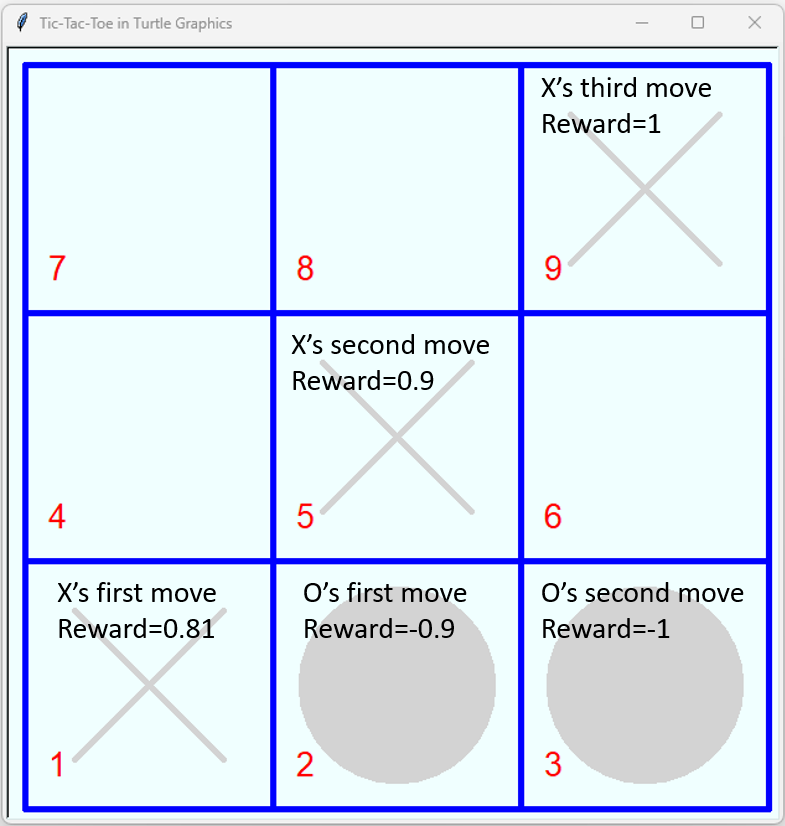

## 1.2. The Credit Assignment Problem in Illegal Moves


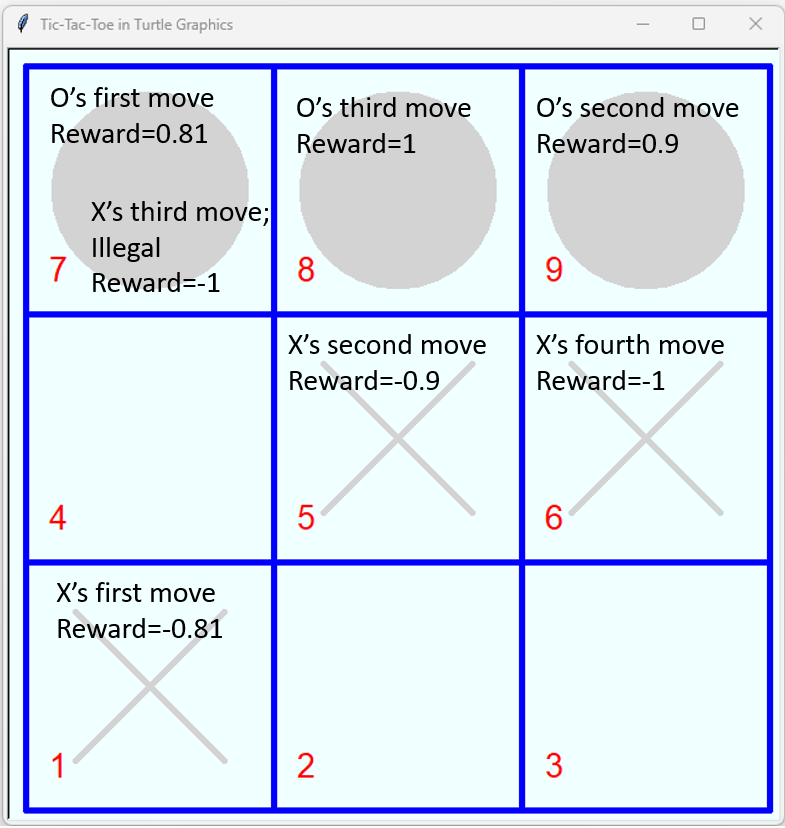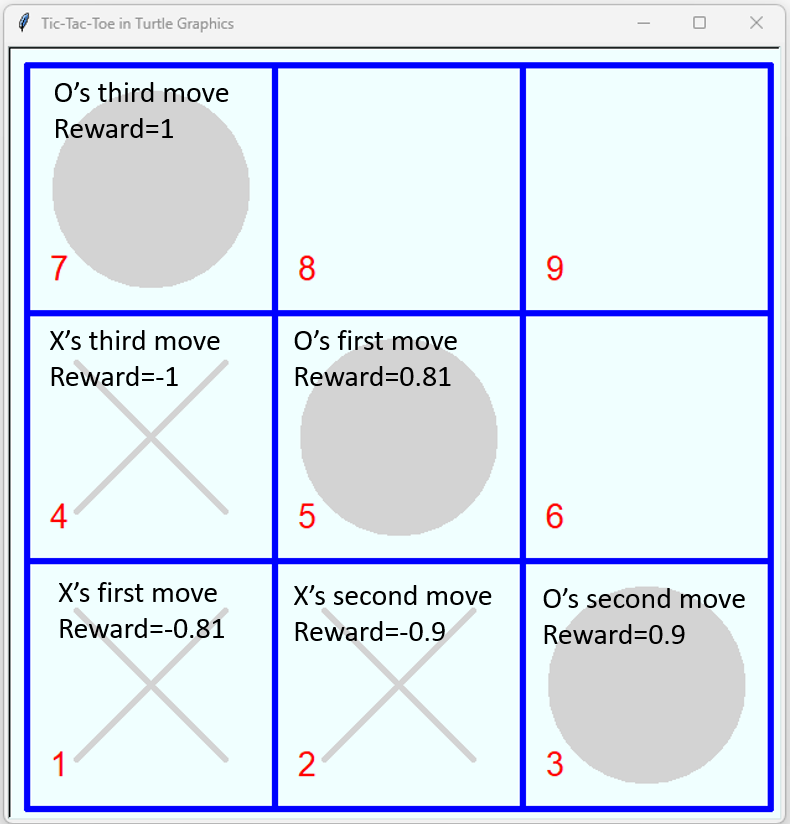

# 2. Use Vectorization to Speed Up Training



In [1]:
import time

start=time.time()
total=0
for i in range(1,10000001):
    total += i
print(f"the sum is {total}")  
end=time.time()
print(f"the calculation took {end-start} seconds to finish")  

the sum is 50000005000000
the calculation took 0.5736210346221924 seconds to finish


In [2]:
import numpy as np

start=time.time()
constant=np.ones(10000000)
numbers=np.arange(10000000)+1
total=np.matmul(constant,numbers)
print(f"the sum is {total}")  
end=time.time()
print(f"the calculation took {end-start} seconds to finish")  

the sum is 50000005000000.0
the calculation took 0.06393122673034668 seconds to finish


# 3. Self-Play Deep Reinforcement Learning in Tic Tac Toe

## 3.1. Combine Two Networks into One


In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

num_inputs = 9
num_actions = 9
num_hidden = 32
# The convolutional input layer
conv_inputs = layers.Input(shape=(3,3,1))
conv = layers.Conv2D(filters=64, kernel_size=(3,3),padding="same",
     input_shape=(3,3,1), activation="relu")(conv_inputs)
# Flatten the output from the conv layer
flat = layers.Flatten()(conv)
# The dense input layer
inputs = layers.Input(shape=(9,))
# Combine the two into a single input layer
two_inputs = tf.concat([flat,inputs],axis=1)
# two hidden layers
common = layers.Dense(128, activation="relu")(two_inputs)
action = layers.Dense(32, activation="relu")(common)
# Policy output network 
action = layers.Dense(num_actions, activation="softmax")(action)
# The final model
model = keras.Model(inputs=[inputs, conv_inputs],\
                    outputs=action)

In [4]:
optimizer=keras.optimizers.Adam(learning_rate=0.0005)

## 3.2. Play Against the Strong Policy Agent


In [5]:
import numpy as np  

# load the trained strong policy model
trained=keras.models.load_model('files/strong_ttt.h5')
# define an opponent for the policy gradient agent
def opponent(env):
    state = env.state.reshape(-1,3,3,1)
    if env.turn=="X":
        action_probs=trained(state)
    else:
        action_probs=trained(-state) 
    aps=[]
    for a in sorted(env.validinputs):
        aps.append(np.squeeze(action_probs)[a-1])
    ps=np.array(aps)/np.array(aps).sum()
    return np.random.choice(sorted(env.validinputs),p=ps)  

In [6]:
from utils.ttt_simple_env import ttt

# allow a maximum of 50 steps per game
max_steps=50
env=ttt()

def playing_X():
    # create lists to record game history
    action_probs_history = []
    wrongmoves_history = []
    rewards_history = []
    state = env.reset()
    episode_reward = 0
    states=[]
    for step in range(max_steps):
        state = state.reshape(-1,9,)
        conv_state = state.reshape(-1,3,3,1)
        # Predict action probabilities and future rewards
        action_probs = model([state,conv_state])
        # select action based on the policy network
        action=np.random.choice(num_actions,\
                                p=np.squeeze(action_probs))
        # record log probabilities
        action_probs_history.append(\
                        tf.math.log(action_probs[0, action]))
        # punish the agent if there is an illegal move
        if action+1 not in env.validinputs:
            rewards_history.append(0)
            wrongmoves_history.append(-1)
        # otherwise, place the move on the game board
        else:              
        # Apply the sampled action in our environment
            state, reward, done, _ = env.step(action+1)
            states.append(state)
            if done:
                wrongmoves_history.append(0)
                rewards_history.append(reward)
                episode_reward += reward 
                break
            else:
                state,reward,done,_=env.step(opponent(env))
                rewards_history.append(reward)
                wrongmoves_history.append(0)
                episode_reward += reward                 
                if done:
                    break                
    return action_probs_history,\
            wrongmoves_history,rewards_history, \
                episode_reward,states,reward

In [7]:
def discount_rs(r,wrong):
    discounted_rs = np.zeros(len(r))
    running_add = 0
    for i in reversed(range(0, len(r))):
        if wrong[i]==0:  
            running_add = gamma*running_add + r[i]
            discounted_rs[i] = running_add  
    return discounted_rs.tolist()

In [8]:
def playing_O():
    # create lists to record game history
    action_probs_history = []
    wrongmoves_history = []
    rewards_history = []
    state = env.reset()
    episode_reward = 0
    states=[]
    # the opponent moves first
    state, reward, done, _ = env.step(opponent(env))
    for step in range(max_steps):
        state = state.reshape(-1,9,)
        conv_state = state.reshape(-1,3,3,1)
        # predict action probabilities; multiply the board by -1
        action_probs = model([-state,-conv_state])
        # select action based on the policy network
        action=np.random.choice(num_actions,\
                                p=np.squeeze(action_probs))
        # record log probabilities
        action_probs_history.append(\
                        tf.math.log(action_probs[0, action]))
        # punish the agent if there is an illegal move
        if action+1 not in env.validinputs:
            rewards_history.append(0)
            wrongmoves_history.append(-1)
        # otherwise, place the move on the game board
        else:              
        # apply the sampled action in our environment
            state, reward, done, _ = env.step(action+1)
            states.append(-state)
            if done:
                wrongmoves_history.append(0)
                rewards_history.append(-reward)
                episode_reward += -reward 
                break
            else:
                state,reward,done,_=env.step(opponent(env))
                rewards_history.append(-reward)
                wrongmoves_history.append(0)
                episode_reward += -reward                 
                if done:
                    break                
    return action_probs_history,\
            wrongmoves_history,rewards_history, \
                episode_reward,states,-reward

## 3.3. Train Players X and O


In [9]:
batch_size=10     
allstates=[]
alloutcome=[]
def create_batch_X(batch_size):
    action_probs_history = []
    wrongmoves_history = []
    rewards_history = []
    episode_rewards = []
    for i in range(batch_size):
        aps,wms,rs,er,ss,outcome = playing_X()
        # rewards are discounted
        returns = discount_rs(rs,wms)
        action_probs_history += aps
        # punishments for wrong moves are not discounted
        wrongmoves_history += wms
        # combine discounted rewards with punishments
        combined=np.array(returns)+np.array(wms)
        # add combined rewards to rewards history
        rewards_history += combined.tolist()
        episode_rewards.append(er)  
        # record game history for the next section
        allstates.append(ss)
        alloutcome.append(outcome)
    return action_probs_history,\
        rewards_history,episode_rewards

In [10]:
def create_batch_O(batch_size):
    action_probs_history = []
    wrongmoves_history = []
    rewards_history = []
    episode_rewards = []
    for i in range(batch_size):
        aps,wms,rs,er,ss,outcome = playing_O()
        # rewards are discounted
        returns = discount_rs(rs,wms)
        action_probs_history += aps
        # punishments for wrong moves are not discounted
        wrongmoves_history += wms
        # combine discounted rewards with punishments
        combined=np.array(returns)+np.array(wms)
        # add combined rewards to rewards history
        rewards_history += combined.tolist()
        episode_rewards.append(er)  
        # record game history for the next section
        allstates.append(ss)
        alloutcome.append(outcome)
    return action_probs_history,\
        rewards_history,episode_rewards

In [11]:
from collections import deque

running_rewards=deque(maxlen=100)
gamma = 0.95  
episode_count = 0
batches=0
# Train the model
while True:
    with tf.GradientTape() as tape:
        if batches%2==0:
            action_probs_history,\
    rewards_history,episode_rewards=create_batch_X(batch_size)
        else:
            action_probs_history,\
    rewards_history,episode_rewards=create_batch_O(batch_size)            
                     
        # Calculating loss values to update our network        
        rets=tf.convert_to_tensor(rewards_history,\
                                  dtype=tf.float32)
        alosses=-tf.multiply(tf.convert_to_tensor(\
          action_probs_history,dtype=tf.float32),rets)
        # Backpropagation
        loss_value = tf.reduce_sum(alosses) 
    grads = tape.gradient(loss_value, model.trainable_variables)
    optimizer.apply_gradients(zip(grads,\
                                  model.trainable_variables))
    # Log details
    episode_count += batch_size
    batches += 1
    running_rewards+=episode_rewards
    running_reward=np.mean(np.array(running_rewards)) 
    # print out progress
    if episode_count % 1000 == 0:
        template = "running reward: {:.6f} at episode {}"
        print(template.format(running_reward, episode_count))   
    # Stop if the game is solved
    if min(running_rewards)>=0 and episode_count>100:  
        print("Solved at episode {}!".format(episode_count))
        break
model.save("files/pg_ttt.h5")                      

In [12]:
import pickle

with open("files/PG_games_ttt.p","wb") as f:
    pickle.dump((allstates,alloutcome),f)

# 4.  Train A Value Network in Tic Tac Toe


## 4.1. The Plan to Train a Value Network


## 4.2. Process the Game Experience Data


In [13]:
with open("files/PG_games_ttt.p","rb") as f:
    history,results=pickle.load(f)              
        
Xs=[]
ys=[]
for states, result in zip(history,results):
    for state in states:
        Xs.append(state)
        if result==1:
            ys.append(np.array([0,1,0]))
        elif result==-1:
            ys.append(np.array([0,0,1]))       
        elif result==0:
            ys.append(np.array([1,0,0]))       
                     
Xs=np.array(Xs).reshape(-1,3,3,1)
ys=np.array(ys).reshape(-1,3)  

## 4.3. Build and Train A Value Network in Tic Tac Toe


In [14]:
from tensorflow.keras.layers import Dense,Conv2D,Flatten
from tensorflow.keras.models import Sequential

value_model = Sequential()
value_model.add(Conv2D(filters=128, 
  kernel_size=(3,3),padding="same",activation="relu",
                 input_shape=(3,3,1)))
value_model.add(Flatten())
value_model.add(Dense(units=64, activation="relu"))
value_model.add(Dense(units=64, activation="relu"))
value_model.add(Dense(3, activation='softmax'))
value_model.compile(loss='categorical_crossentropy',
                   optimizer='adam', 
                   metrics=['accuracy']) 

In [15]:
# Train the model for 50 epochs
value_model.fit(Xs, ys, epochs=50, verbose=1)
value_model.save('files/value_ttt.h5')  

# 5. Play Tic Tac Toe with the Value Network


## 5.1. Game Strategies Based on the Value Network


In [16]:
# design game strategy
from copy import deepcopy

def best_move(env):
    # Set the initial value of bestoutcome        
    bestoutcome=-2;
    bestmove=None    
    #go through all possible moves hypothetically 
    for move in env.validinputs:
        env_copy=deepcopy(env)
        state,reward,done,info=env_copy.step(move)
        state=state.reshape(-1,3,3,1)
        if env.turn=="X":
            ps=value_model.predict(state,verbose=0)
        else:
            ps=value_model.predict(-state,verbose=0)
        # output is prob(win) - prob(lose)
        win_lose_dif=ps[0][1]-ps[0][2]
        if win_lose_dif>bestoutcome:
            # Update the bestoutcome
            bestoutcome = win_lose_dif
            # Update the best move
            bestmove = move
    return bestmove   

## 5.2. Test the Value Network Agent Against the Strong Policy Agent 


In [17]:
# test ten games when the value network agent moves first
for i in range(10):
    state=env.reset()  
    while True: 
        # move recommended by the value network
        action=best_move(env)  
        state,reward,done,_=env.step(action)
        # print game outcome 
        if done:
            if reward==0:
                print("It's a tie!")
            else:
                print("The value network wins!")
            break
        # The strong policy agent moves second
        action=opponent(env)
        state,reward,done,_=env.step(action)     
        # print game outcome if the game ends
        if done:
            if reward==0:
                print("It's a tie!")
            else:            
                print("The value network loses!")
            break

It's a tie!
It's a tie!
It's a tie!
It's a tie!
It's a tie!
It's a tie!
It's a tie!
It's a tie!
It's a tie!
It's a tie!


In [18]:
# test against the strong policy agent
# test ten games when move second
for i in range(10):
    state=env.reset()  
    # The AI player moves firsts 
    action=opponent(env)
    state,reward,done,_=env.step(action)
    while True: 
        # move recommended by the value network
        action=best_move(env)  
        state,reward,done,_=env.step(action)
        # if value network wins, record 1
        if done:
            if reward==0:
                print("It's a tie!")
            else:
                print("The value network wins!")
            break
        # The AI player moves
        action=opponent(env)
        state,reward,done,_=env.step(action)     
        # if value network wins, record 1
        if done:
            if reward==0:
                print("It's a tie!")
            else:            
                print("The value network loses!")
            break

It's a tie!
It's a tie!
It's a tie!
It's a tie!
It's a tie!
It's a tie!
It's a tie!
It's a tie!
It's a tie!
It's a tie!
